# Introducing a validation loss

This notebook aims at introducing the usage of a validation module in **jinns**

For this, we will use an SPINN network to solve Fisher KPP on bounded domain in 1D and monitor the loss on a validation set.


$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x)=D\frac{\partial^2}{\partial x^2} u(t,x) + u(t,x)(r(x) - \gamma(x)u(t,x)), t\geq 0, x\in [0,l]\\
u(t,0)=u(t,l)=0,t\geq 0, \text{Dirichlet condition}\\
u(0,x)=u_0(x),x\in [0,l]
\end{cases}
$$

In all that follows, $r(x)$, $\gamma(x)$ et $D$ are considered constant.

For more details about this experiment, see also the notebook _Fisher KPP on bounded domain in 1D (PINN and SPINN)_


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import our package

In [2]:
import jinns


Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)


2024-11-18 14:27:43.056687: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Create the SPINN

In [4]:
d = 2
r = 256
eqx_list = [
    [eqx.nn.Linear, 1, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, r],
]
key, subkey = random.split(key)
u_spinn, init_nn_params_spinn = jinns.utils.create_SPINN(subkey, d, r, eqx_list, "nonstatio_PDE")

Create a DataGenerator object for the training data

In [5]:
n = 1000
nb = 1000
ni = 1000
domain_batch_size = 32
initial_batch_size = 32
border_batch_size = 32
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
method = "uniform"

Tmax = 5

key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    domain_batch_size=domain_batch_size,
    border_batch_size=border_batch_size,
    initial_batch_size=initial_batch_size,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax
)


## Set up the initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

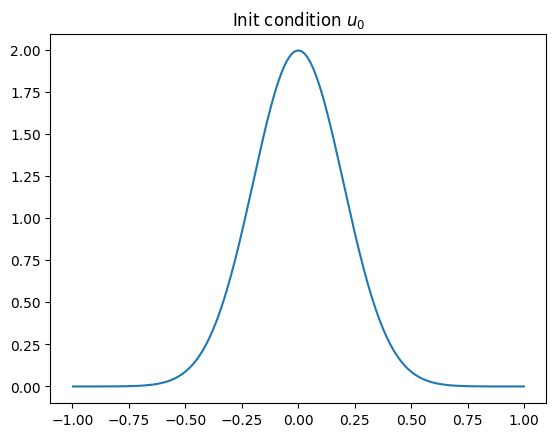

In [6]:
from jax.scipy.stats import norm
# true solution N(0,1)
sigma_init = 0.2 * jnp.ones((1))
mu_init = 0 * jnp.ones((1))

def u0(x):
    return jnp.squeeze(norm.pdf(x, loc=mu_init, scale=sigma_init))

plt.plot(train_data.domain[:,1].sort(axis=0), vmap(u0, (0), 0)(train_data.domain[:,1].sort(axis=0)))
plt.title(r"Init condition $u_0$")

## Model parameters

In [7]:
# Example III.29 is persistent with D = 1, r = 4,  g = 3
D = 1.
r = 4.
g = 3.
l = xmax - xmin
boundary_condition = "dirichlet"
omega_boundary_fun = lambda t_dx: 0 # cte func returning 0

Thes loss' `evaluate` method requires a `Params` object, which is an Equinox Module with neural network parameters in the field `nn_params` and the equation parameters in the field `eq_params`. 

In [8]:
init_params_spinn = jinns.parameters.Params(
    nn_params=init_nn_params_spinn,
    eq_params= {
        "D":jnp.array([D]),
        "r":jnp.array([r]),
        "g":jnp.array([g])
    }
)

## Loss construction

In [9]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax
)

Loss for the SPINN

In [10]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=1 * Tmax, boundary_loss=1 * Tmax
)

loss_spinn = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=boundary_condition,
    initial_condition_fun=u0,
    params=init_params_spinn
)

## Setting up the validation step

**Create a DataGenerator object for the validation data**: The same as for the train data but we do not want mini-batches over the validation dataset. We simply let the size of the batch be the total size of the dataset `omega_batch_size=n` and `temporal_batch_size=nt`.

In [11]:
n = 1000
nb = 1000
ni = 1000
domain_batch_size = 32
initial_batch_size = 32
border_batch_size = 32
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
method = "uniform"

Tmax = 5

key, subkey = random.split(key)
validation_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    domain_batch_size=domain_batch_size,
    border_batch_size=border_batch_size,
    initial_batch_size=initial_batch_size,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax
)


Here, we work with a vanilla validation procedure already implemented in **jinns** by the `ValidationLoss` module. This consists of evaluating the whole loss on a validation dataset and optionally triggering (or not) an early stopping procedure. The `call_every` attribute represents how often the validation step is called during training, and the 
patience parameter controls how many non-improving validaiton iterations should be spent before early stoping. If `validation.early_stopping` is `False`, then we never break out of training and only return the monitored validation 
loss every `call_every` iterations.


**Note**: the **jinns** package allow user to define their own validation procedure on the form of `eqx.Module` (see [Equinox documentation](https://docs.kidger.site/equinox/api/module/module/)). The latter must subclass `jinns.validation.AbstractValidationModule` with a `call_every` attribute and a `__call__(self, params)` method. For more details, look at the `ValidationLoss` module source code. It could be easily modified to focus on certain loss terms, or a totally different criterion that user may find relevant for validation purpose, although we won't illustrate this in this Notebook.

**Note that for illustration purpose (to force the triggering of an early stopping) the `call_every` argument is too low, yielding results much before a proper convergence**

In [12]:
from jinns.validation import ValidationLoss
validation = ValidationLoss(
    loss = loss_spinn,
    validation_data = validation_data,
    validation_param_data = None,
    validation_obs_data = None,
    call_every=250,
    early_stopping=True,
    patience=10
)

In [13]:
params_spinn = init_params_spinn
import optax
tx = optax.adamw(learning_rate=1e-4)
n_iter = 50000
params_spinn, train_loss_values, _, _, _, _, _, validation_loss_values, best_params_spinn = jinns.solve(
    init_params=params_spinn,
    data=train_data,
    optimizer=tx,
    loss=loss_spinn,
    n_iter=n_iter,
    validation=validation
)


Compilation took
 9.63166856765747 

[train] Iteration 0: loss value = 9.222553253173828
[validation] Iteration 0: loss value = 4.970238208770752
[train] Iteration 1000: loss value = 1.1156318187713623
[validation] Iteration 1000: loss value = 1.6820015907287598
[train] Iteration 2000: loss value = 1.364681601524353
[validation] Iteration 2000: loss value = 1.1231725215911865
[train] Iteration 3000: loss value = 1.1115683317184448
[validation] Iteration 3000: loss value = 1.9575241804122925
[train] Iteration 4000: loss value = 1.6374543905258179
[validation] Iteration 4000: loss value = 1.632851481437683
[train] Iteration 5000: loss value = 1.62820565700531
[validation] Iteration 5000: loss value = 1.4333765506744385

Stopping main optimization loop, cause: early stopping

Training took
 8.161399602890015 


Final iteration 5001: train loss value = 1.62820565700531
validation loss value = 1.4333765506744385

 Returning a set of best parameters from early stopping as last argument!
 Be

Note that `solve()` returns the `jnp.array` of our validation criterion as an extra argument (here the validation PINN loss) if `validation` is provided.

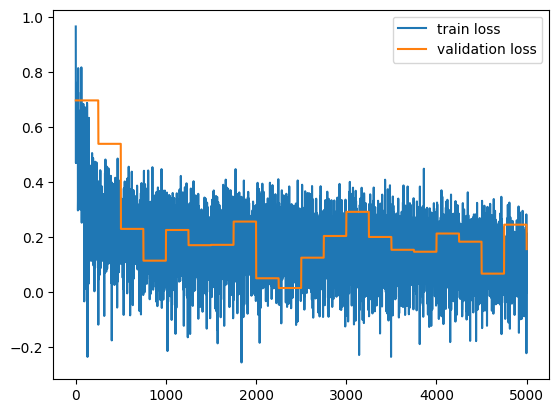

In [14]:
plt.plot(jnp.log10(train_loss_values), label="train loss")
plt.plot(jnp.log10(validation_loss_values), label="validation loss")
plt.legend()
plt.show()

In [15]:
nx = 500
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 500
val_times = jnp.linspace(tmin, tmax, ntime)

We can now use the best_parameters `best_params_spinn`, with respect to the validation criterion and display the solution.

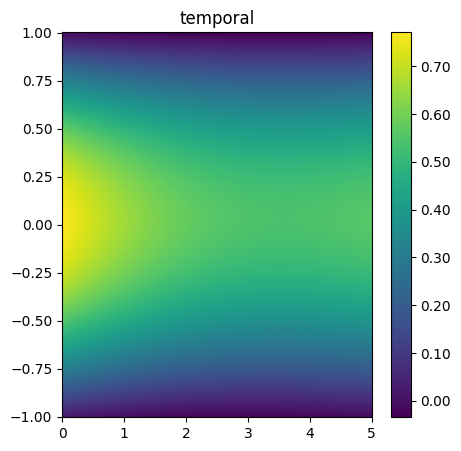

In [16]:
u_est_spinn = lambda t_x: u_spinn(t_x, best_params_spinn.nn_params)
# same subkey
jinns.plot.plot1d_image(u_est_spinn, xdata=val_xdata, times=val_times, Tmax=Tmax, cmap="viridis", colorbar=True, figsize=(5, 5), title="temporal", spinn=True)

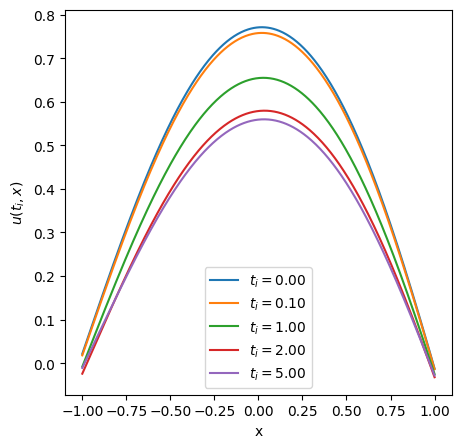

In [17]:
time_slices = [0, 0.02, 0.2, 0.4, 1]
jinns.plot.plot1d_slice(u_est_spinn, xdata=val_xdata, time_slices=time_slices, Tmax=Tmax, figsize=(5, 5), spinn=True)